In [89]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns

In [90]:
def sum_df_rewards(df, columns, denominator=1, col_title='Total Return'):
    '''
    Sums all columns per row, where the summed columns are not in 'columns'
        df : pandas DataFrame
        columns : list 
            columns not to be summed
    '''
    df = df.set_index(columns)
    df = df.sum(axis=1).div(denominator)
    
    df = df.reset_index()

    df.columns = columns + [col_title]

    return df

def cumsum_df_rewards(df, columns):
    '''
    Sums all columns per row, where the summed columns are not in 'columns'
        df : pandas DataFrame
        columns : list 
            columns not to be summed
    '''
    df = df.set_index(columns)
    df = df.cumsum(axis=1)
    df = df.reset_index()
    
    return df

# Demonstrations Distribution

In [91]:
from lfh.utils.io import load_demonstrations
demonstration_rewards = load_demonstrations("BreakoutDemonstrations", return_demonstrations=False)

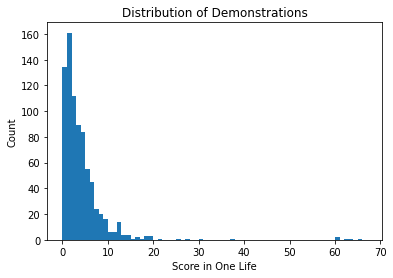

In [92]:
plt.hist(demonstration_rewards, bins = np.arange(0, np.max(demonstration_rewards)))
plt.title("Distribution of Demonstrations")
plt.xlabel("Score in One Life")
plt.ylabel("Count")
plt.savefig("figures\\demonstration_distribution.pdf")

# Rewards

In [93]:
all_play_returns = []
all_test_returns = []

results_root = Path("..")/ "results"

min_num_episodes = 100000000

for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)
    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None


    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        all_play_returns.append([agent, offset, radius, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = test_returns.flatten() #np.mean(test_returns, axis=1)
        
        if len(test_returns) > 500:
            test_returns = test_returns[1::2] # every second 

       

        all_test_returns.append([agent, offset, radius, mix_ratio] + list(test_returns))


In [94]:
cat_cols = ["agent", "offset", "radius", "mix ratio"]
cols = cat_cols + list(range(500))
all_test_returns = pd.DataFrame(data= all_test_returns, columns = cols )

for i in range(len(all_play_returns)):
    all_play_returns[i] = all_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
all_play_returns = pd.DataFrame(data= all_play_returns, columns = cols )

## n best configurations

In [95]:
def add_config(df):
    df['Config'] = df["agent"].str.cat(df['offset'].astype(str), sep = " o: ").str.cat(df['radius'].astype(str), sep = " r: ").str.cat(df['mix ratio'].astype(str), sep = " mr: ")   
    df = df.replace(to_replace=r' .*nan', value='', regex=True)

    return df 

In [96]:
def get_n_best(df, cat_cols, n):
    sum_df = sum_df_rewards(df, cat_cols, denominator=1, col_title='Total Return') #sum of returns
    sum_df = sum_df.groupby(cat_cols).mean() # take mean across seeds
    sum_df = sum_df.nlargest(n,"Total Return") # highest returns

    n_best_idx = sum_df.index.tolist() # n configurations  of ZPD with highest overall return
    return n_best_idx

In [97]:
def plot_n_best(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel=''):
    n_best_idx = get_n_best(df, cat_cols, 1)
    df = df.set_index(cat_cols)


    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
        
    n_best_df = df.loc[n_best_idx]

    n_best_df = n_best_df.reset_index()
    
    
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    n_best_df = n_best_df.append(df[df["agent"] == "unseq_DDQN"])
    n_best_df = n_best_df.append(df[df["agent"] == "DDQN"])

    n_best_df = add_config(n_best_df)
    n_best_df =n_best_df.replace(to_replace=r'nan:', value='', regex=True)
    n_best_df  =n_best_df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(n_best_df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward", hue="Config", ci = None, kind='line', data=df_melt)
    plot.set(xlabel=xlabel, ylabel=ylabel)


### n best play returns over rolling average

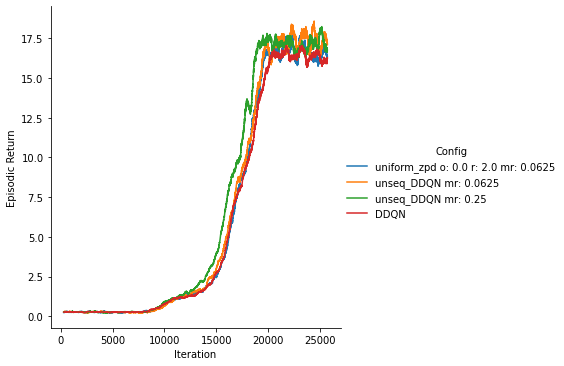

In [98]:
plot_n_best(all_play_returns, cat_cols, min_num_episodes, rolling=True, rolling_window = 300,xlabel="Iteration", ylabel="Episodic Return")

plt.savefig("figures/best_episodic_play_rolling_avg_window_300.pdf", bbox_inches = "tight")

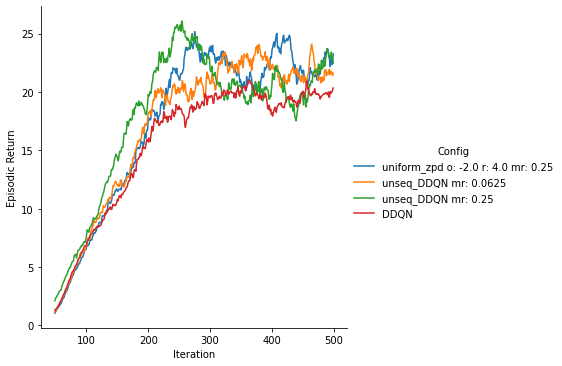

In [99]:
plot_n_best(all_test_returns, cat_cols, 500, rolling=True, rolling_window=50, xlabel="Iteration", ylabel="Episodic Return")

plt.savefig("figures/best_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

## Cumulative

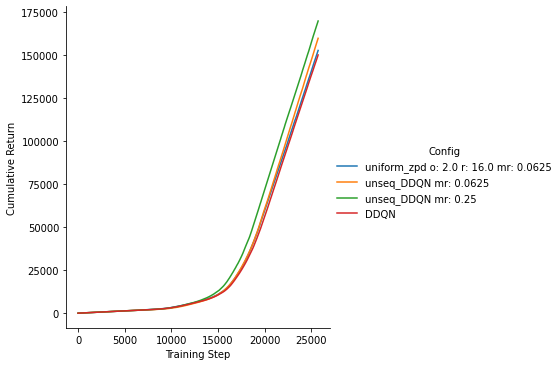

In [100]:
# Play
plot_n_best(cumsum_df_rewards(all_play_returns, cat_cols), cat_cols, min_num_episodes, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/best_cumulative_play.pdf", bbox_inches = "tight")

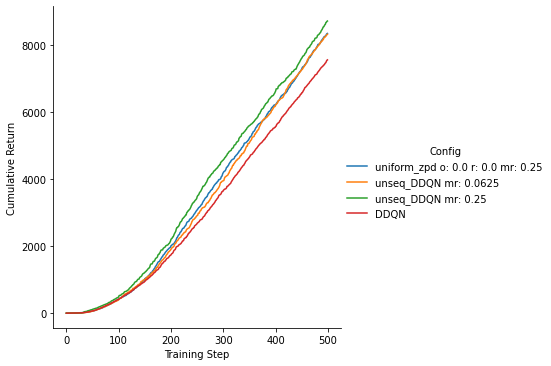

In [101]:
# test
plot_n_best(cumsum_df_rewards(all_test_returns, cat_cols), cat_cols, 500, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/best_cumulative_test.pdf", bbox_inches = "tight")

# Effect of mix ratio, width, offset

In [102]:
def plot_params(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel=''):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df=df.replace(to_replace=r'nan:', value='', regex=True)
    df =df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward", hue="radius",ci = None, kind='line', row='mix ratio', col='offset', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)


In [118]:
def plot_offset(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel=''):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df=df.replace(to_replace=r'nan:', value='', regex=True)
    df =df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward",ci = None, kind='line', col='mix ratio', hue='offset', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)


In [ ]:
def plot_radius(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel=''):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)
    df=df.replace(to_replace=r'nan:', value='', regex=True)
    df =df.replace(to_replace=r'nan', value='', regex=True)
    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    plot = sns.relplot(x="Step", y= "Reward",ci = None, kind='line', col='mix ratio', hue='radius', data=df_melt, palette=sns.color_palette("crest", as_cmap=True))
    plot.set(xlabel=xlabel, ylabel=ylabel)

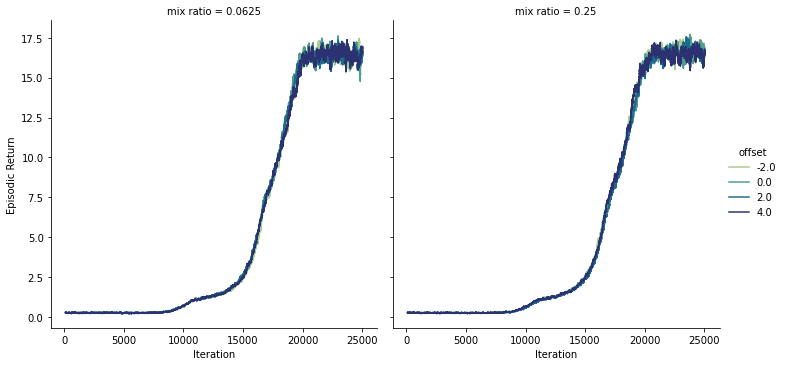

In [119]:
# play
plot_offset(all_play_returns, cat_cols, min_num_episodes,rolling = True, rolling_window = 100, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/param_offset_episodic_play_rolling_avg_window_100.pdf", bbox_inches = "tight")

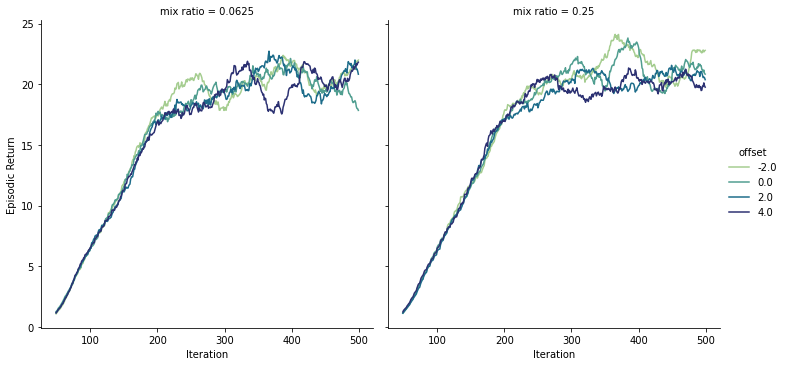

In [120]:
# test
plot_offset(all_test_returns, cat_cols, 500, rolling = True, rolling_window = 50, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/param_offset_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

In [ ]:
# play
plot_radius(all_play_returns, cat_cols, min_num_episodes,rolling = True, rolling_window = 100, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/param_radius_episodic_play_rolling_avg_window_100.pdf", bbox_inches = "tight")

In [ ]:
# play
plot_radius(all_test_returns, cat_cols, min_num_episodes,rolling = True, rolling_window = 100, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/param_radius_episodic_play_rolling_avg_window_100.pdf", bbox_inches = "tight")

In [ ]:
# test
plot_offset(all_test_returns, cat_cols, 500, rolling = True, rolling_window = 50, xlabel="Iteration", ylabel="Episodic Return")

plt.savefig("figures/param_episodic_test_rolling_avg_window_50.pdf", bbox_inches = "tight")

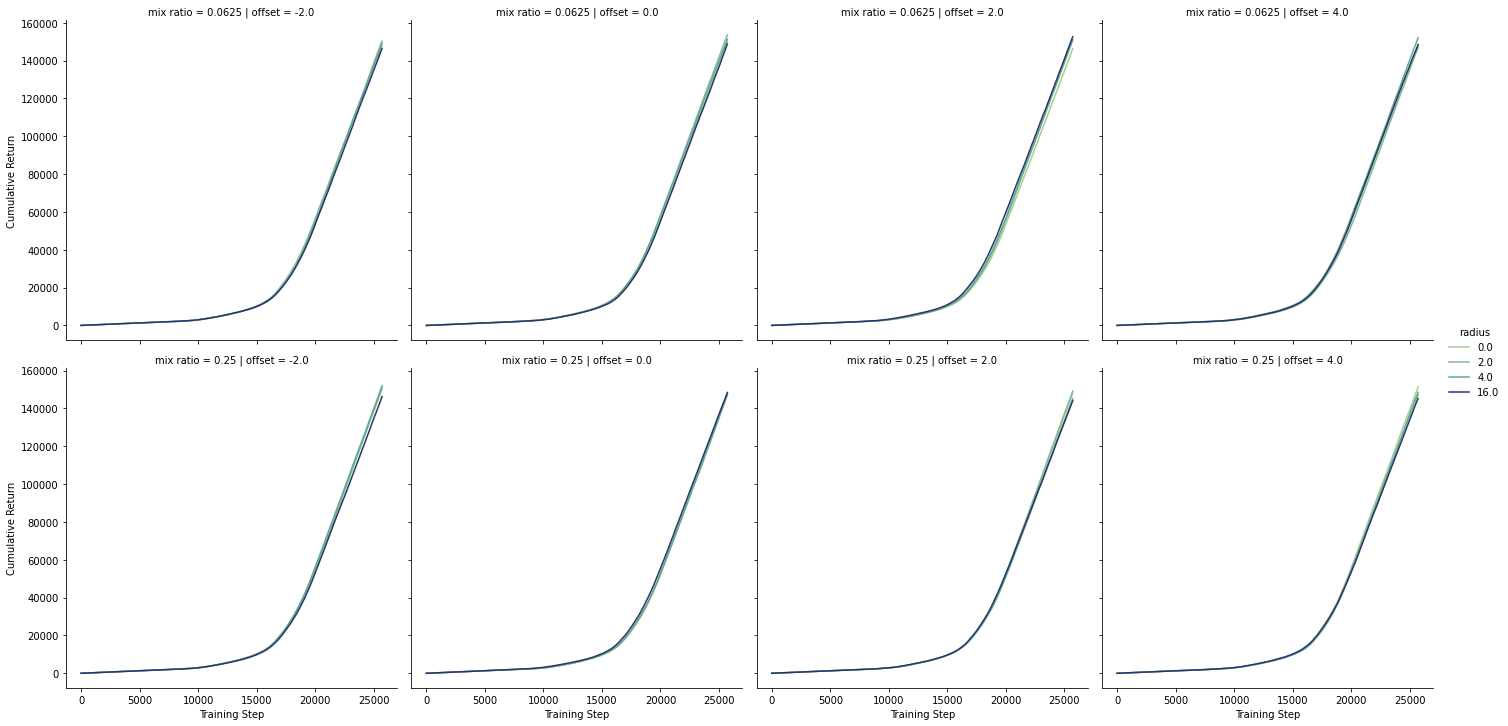

In [105]:
# play
plot_params(cumsum_df_rewards(all_play_returns,cat_cols), cat_cols, min_num_episodes, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/param_cumulative_play.pdf", bbox_inches = "tight")

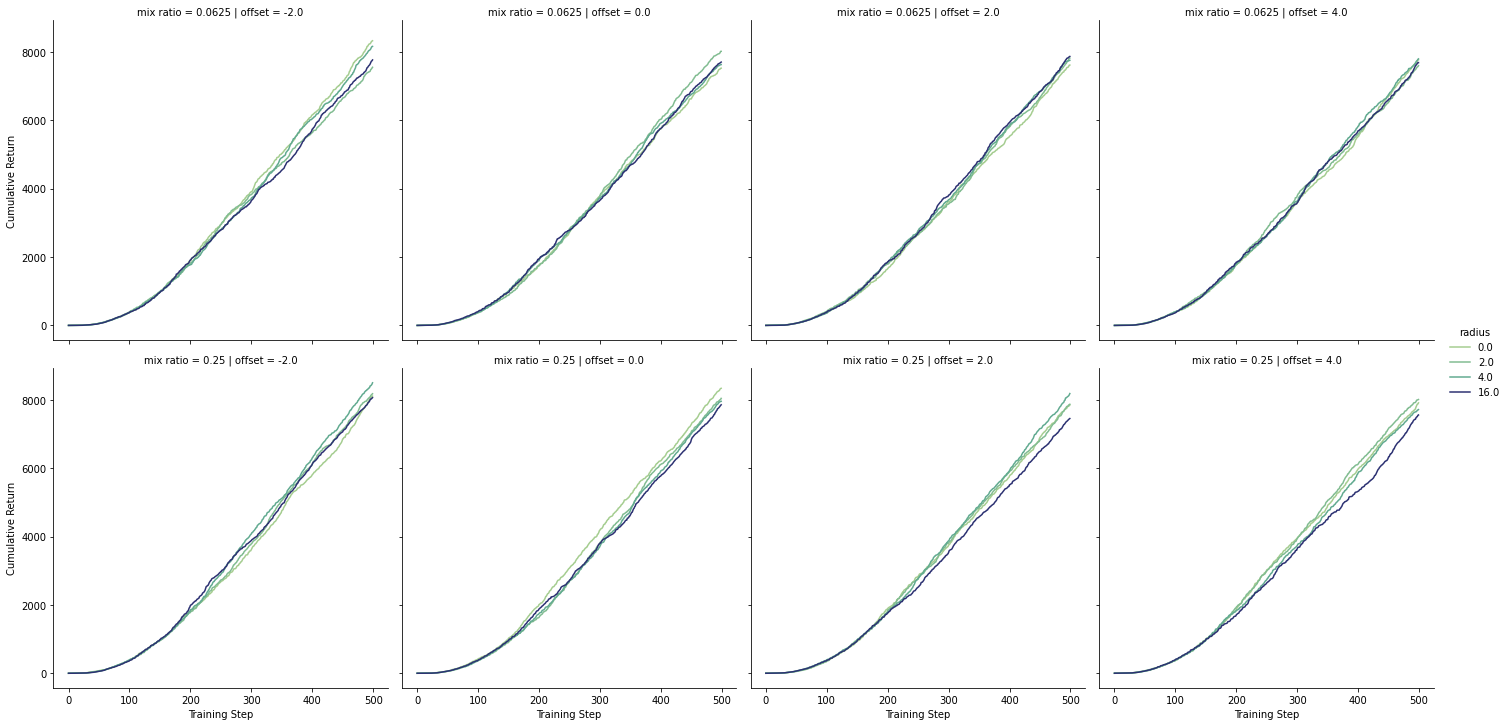

In [106]:
# test
plot_params(cumsum_df_rewards(all_test_returns,cat_cols), cat_cols, 500, xlabel="Training Step", ylabel="Cumulative Return")
plt.savefig("figures/param_cumulative_test.pdf", bbox_inches = "tight")

# Loss Ablations

In [107]:
# load supervised results
sup_play_returns = []
sup_test_returns = []

results_root = Path("..")/ "results_supervised"

min_num_episodes = 100000000

for subdir in [x for x in results_root.iterdir() if x.is_dir()]:

    # load in parameters
    with open(str(subdir/"params.txt")) as f:
        params = json.load(f)
    agent = params["agent"]

    if agent == "uniform_zpd":
        offset = params["zpd"]["offset"]
        radius = params["zpd"]["radius"]
    else:
        offset = None
        radius = None
    
    if agent != "DDQN":
        mix_ratio = params["zpd"]["mix_ratio"]
    else:
        mix_ratio = None


    # load play returns
    play_returns_path = subdir/"play_returns.npy"
    if play_returns_path.exists():
        play_returns = np.load(play_returns_path)
        if len(play_returns) < min_num_episodes:
            min_num_episodes = len(play_returns)
        sup_play_returns.append([agent, offset, radius, mix_ratio] + list(play_returns))
    
    # load test returns
    test_returns_path = subdir/"test_returns.npy"
    if test_returns_path.exists():
        test_returns = np.array(np.load(test_returns_path))
        test_returns = test_returns.flatten() #np.mean(test_returns, axis=1)
        
        if len(test_returns) > 500:
            test_returns = test_returns[1::2] # every second 

       

        sup_test_returns.append([agent, offset, radius, mix_ratio] + list(test_returns))

In [108]:
cat_cols = ["agent", "offset", "radius", "mix ratio"]
cols = cat_cols + list(range(500))
sup_test_returns = pd.DataFrame(data= sup_test_returns, columns = cols )

for i in range(len(sup_play_returns)):
    sup_play_returns[i] = sup_play_returns[i][:min_num_episodes + len(cat_cols)]

cols = cat_cols + list(range(min_num_episodes))
sup_play_returns = pd.DataFrame(data= sup_play_returns, columns = cols )


sup_test_returns.insert(0, "Supervised", "True")
sup_play_returns.insert(0, "Supervised", "True")

In [109]:
all_test_returns.insert(0, "Supervised", "False")
all_play_returns.insert(0, "Supervised", "False")

In [110]:
test_returns = sup_test_returns.append(all_test_returns)
play_returns = sup_play_returns.append(all_play_returns)

test_returns = test_returns[test_returns["mix ratio"] == 1/4]
play_returns = play_returns[play_returns["mix ratio"] == 1/4]

In [111]:
test_returns

,Supervised,agent,offset,radius,mix ratio,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,499
0,True,uniform_zpd,-2.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,...,16.0,14.0,2.0,1.0,1.0,12.0,13.0,5.0,52.0,11.0
1,True,uniform_zpd,0.0,2.0,0.25,0.0,0.0,0.0,0.0,0.0,...,20.0,8.0,7.0,1.0,5.0,16.0,5.0,6.0,3.0,1.0
2,True,uniform_zpd,-2.0,16.0,0.25,0.0,0.0,0.0,0.0,0.0,...,24.0,18.0,4.0,2.0,0.0,24.0,18.0,4.0,2.0,0.0
3,True,uniform_zpd,0.0,16.0,0.25,0.0,0.0,0.0,0.0,0.0,...,2.0,12.0,3.0,12.0,53.0,2.0,12.0,3.0,12.0,53.0
4,True,uniform_zpd,0.0,4.0,0.25,0.0,1.0,0.0,0.0,0.0,...,22.0,5.0,8.0,45.0,0.0,22.0,5.0,8.0,45.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,False,uniform_zpd,4.0,0.0,0.25,0.0,0.0,2.0,0.0,0.0,...,17.0,26.0,32.0,7.0,1.0,86.0,6.0,28.0,6.0,3.0
115,False,uniform_zpd,4.0,2.0,0.25,1.0,1.0,1.0,1.0,1.0,...,7.0,49.0,6.0,12.0,7.0,49.0,6.0,12.0,7.0,13.0
116,False,uniform_zpd,4.0,16.0,0.25,2.0,1.0,1.0,1.0,1.0,...,4.0,59.0,3.0,0.0,0.0,31.0,1.0,1.0,14.0,31.0
118,False,unseq_DDQN,NaN,NaN,0.25,0.0,0.0,0.0,0.0,0.0,...,15.0,22.0,6.0,91.0,2.0,18.0,74.0,18.0,74.0,18.0


In [112]:
def plot_ablation(df, cat_cols, num_episodes, rolling = False, rolling_window = 30, xlabel='', ylabel=''):
    df = df.set_index(cat_cols)
    if rolling:
        df = df.rolling(rolling_window, axis =1 ).mean()
    # add back DDQN and unseq DDQN
    df = df.reset_index()
    df= add_config(df)

    df_melt = pd.melt(df, id_vars= cat_cols + ["Config"], var_name = "Step",value_name= "Reward", value_vars=list(range(0, num_episodes)))

    #plot = sns.relplot(x="Step", y= "Reward", hue="Supervised",ci = None, kind='line', row='radius', col='offset', data=df_melt)
    plot = sns.relplot(x="Step", y= "Reward", hue="Supervised",ci = None, kind='line', data=df_melt)
    plot.set(xlabel=xlabel, ylabel=ylabel)

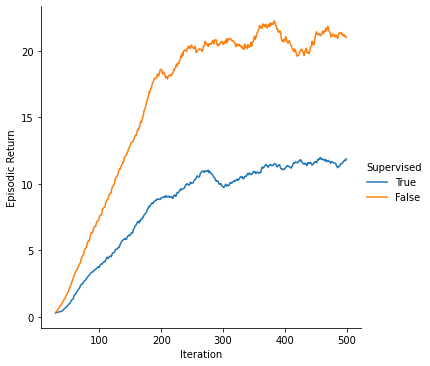

In [113]:
plot_ablation(test_returns, cat_cols + ["Supervised"], 500, rolling = True, rolling_window = 30, xlabel="Iteration", ylabel="Episodic Return")
plt.savefig("figures/ablation.pdf", bbox_inches='tight')